# Technical Support Engineer Challenge
#### for a fictional analysis delivered to  <span style="color:green">Green-Plant Gmbh</span> via UP42 <br/> 
#### 🪐 A Jupyter Notebook workflow by team candidate Jesse Smith 🗺️ 

## Install and import requisite modules
👋 Hello, and thank you for taking the time to review my notebook!

The following modules were used to complete the challenge: 

- up42-py (UP42 Python SDK)
- numpy
- pandas
- rasterio
- geopandas
- matplotlib

I noted that the PDF requested just numpy, pandas, and rasterio, but I wanted to do some clipping to the AOI and make visualizations, so I took geopandas and matplotlib along for the ride, too.

In [1]:
#importing required libraries; have included matplotlib for plotting outputs, and os/pathlib for file management:
#I like to build a pyramid :)

import os
import up42
import pathlib
import rasterio
import numpy as np 
import pandas as pd
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Housekeeping

First, a quick primer. The objective is to provide some analysis to Green-Plant focussed on NDVI over their AOI. In case the client  is not sure what NDVI is or does:

**NDVI (Normalized Vegetation Difference Index)** is a popular measurement used for ranking the health and density of live vegetation. It is important to note it is unitless, and differences between values are relative. NDVI values can range from -1 to +1, with the closer the value is to +1, the healthier and denser the vegetation. e.g. you can indicate that high values of NDVI are "better" than low ones, but the numbers are not amounts of chlorophyll. 

Sometimes, these values can be reclassified (or "binned") into categories. Those below 0 usually indicate water or the presence of built-up urban features (otherwise irrelevant things in this context). Low positive values can indicate bare ground, soil, or dry substrate. Once over 0.5, moderate to increasing density and health are expected. Therefore, by collecting relevant imagery over the AOI, and calculating NDVI for these images, it is possible to target areas of vegetation growth or decline. Remotely!

### Getting things started, familiarizing with the Amazonas AOI included in the challenge document.
In the code below, I:
1. Imported the AOI data hyper-linked in the challenge PDF (_amazonas.geojson_);
2. Returned its extent information in order to query the UP42 catalogue for relevant S-2 scenes (later);
3. Approximated the AOI's UTM Zone, in order to determine a projected coordinate system;
4. Used the projected coordinate system to calculate the AOI area in nice SI units, in order to have a better sense of project scale, and make decisions accordingly.

I determined _amazonas.geojson_ to be an easy enough area to work with (793 km<sup>2</sup>) and decided to not further reduce its size.

The AOI is located in Matto Grosso, Brazil, and is characterized by a tropical humid climate.


In [47]:
#set path relative to root of repo to AOI geoJSON. 
root = os.getcwd()
path = pathlib.Path(root, "data/amazonas.geojson")

#read in the Amazonas AOI and get the bounds:
aoi = gpd.read_file(path)
bounds = aoi.total_bounds.tolist()
print("Bottom left and top right coords, respectively:", bounds)

#estimate the UTM zone
long = bounds[0] + 180 
zone = np.round(long/6,0) 
print("UTM zone is ~", zone, 'S', "which corresponds to EPSG code 32521") #looked up the EPSG code for UTM 21S

#Find area of original AOI:
copy = aoi.copy()
copy.head()
copy = copy.to_crs({'init': 'epsg:32521'})
copy.crs
copy["area"] = copy['geometry'].area/ 10**6 #square metres to square km conversion. 
print("Central northings/eastings of AOI:", copy.centroid.y.values[0], ",", copy.centroid.x.values[0])

#The AOI is not so large that it requires an equal area projection. 
#We will stick with the estimated based on UTM Zone 21S. 
print("Project area is", round(copy["area"].values[0],1), "km^2")

Bottom left and top right coords, respectively: [-55.80602463366668, -13.49938970772358, -55.520612343249226, -13.267580954511516]
UTM zone is ~ 21.0 S which corresponds to EPSG code 32521
Central northings/eastings of AOI: 8520060.886173286 , 644713.4423905695
Project area is 792.6 km^2


# Initialize the UP42 SDK

I removed my temporary credentials from here operating on the assumption I shouldn't leave these in a public repo, and that the reviewers could substitute their own. 

If needed I am happy to supply the temp credentials however UP42 sees fit!

In [3]:
#authenticate with UP42:
up42.authenticate(
    username="",
    password="",
)

2023-12-07 14:07:12,669 - Authentication with UP42 successful!


# Get Sentinel-2 data products from UP42 catalog
### Now it's time to work with the UP-42 SDK.

Below I: <br>
- Returned a catalogue with all collections types;
- Selected ID corresponding to level 2-A Sentinel-2 assets, which are surface reflectance pixel values.
- This makes it possible to combine time series analyses across a mix of sensors (e.g. LANDSAT series);
- This is important if Green-Plant Gmbh wishes to extend its analyses _prior_ to June 2015, when Sentinel-2 became operational, and continue their time series analyses with additional sensors (such as the LANDSAT series, which has similar radiometric bands, but at a poorer spatial resolution).

**The surface reflectance product is important because surface reflectance image pixel are standardized to % of light reflected from below the atmosphere, so the data is uncontaminated by atmospheric effects (except for cloud), and aesthetic image enhancements, both of which can skew "true" NDVI values.**

In [4]:
catalog = up42.initialize_catalog()
data_products = catalog.get_data_products(basic=True) #all data products
data_product_id = catalog.get_data_products(basic=True).get("Sentinel-2").get("data_products").get("Level-2A") #S-2 L2A

## Re: Concerns about data availability 

I noted <span style="color:green">Green-Plant</span> is concerned by the potential for data paucity of Sentinel 2 over their AOI. 

To address this, I ran a loop that aggregated the number of images available throughout the years, with different cloud cover percentages. Then below, the results were visualized in a bar chart. This is to show they have quite a bit of options, annually, with low cloud cover obstruction.

- Green-Plant should be relieved to know there is quite a bit of data availability from the last seven years at least;
- There's 169 scenes with <= 5% cloud cover;
- This raises to 264 when maximum cloud cover is increased to 25%;
- Below is a plot showing image availability with increased maximum cloud coverage (x-axis). The number of images per year is expressed in the colour blocks within each bar;
- Hopefully this helps assuage Green-Plant's concerns!

In [25]:
results = []
cloudcover = []
year = []

for i in range(1,26):
    search_results = catalog.search(search_parameters=catalog.construct_search_parameters(
        geometry= bounds,
        start_date="2015-06-24", 
        end_date="2023-12-05",
        collections=[data_products.get("Sentinel-2").get("collection")],
        max_cloudcover=i, 
        limit=300))

    search_copy = search_results.copy()
    search_copy["year"] = search_copy["acquisitionDate"].str[:4]
        
    for annum in range(2017,2024):
        results.append(len(search_copy[search_copy["year"] == str(annum)]))
        cloudcover.append(i)    
        year.append(annum)

2023-12-07 14:43:34,232 - Searching catalog with search_parameters: {'datetime': '2015-06-24T00:00:00Z/2023-12-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358)),)}, 'limit': 300, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 1}}}
2023-12-07 14:43:39,576 - 97 results returned.
2023-12-07 14:43:39,618 - Searching catalog with search_parameters: {'datetime': '2015-06-24T00:00:00Z/2023-12-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358)),)}, 'limit': 300, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lt

## Data visualization cleaning

Below are some cleaning steps (changing the search results dataframe from long to wide mode to make a bar chart, and building the bar chart aesthetic.)

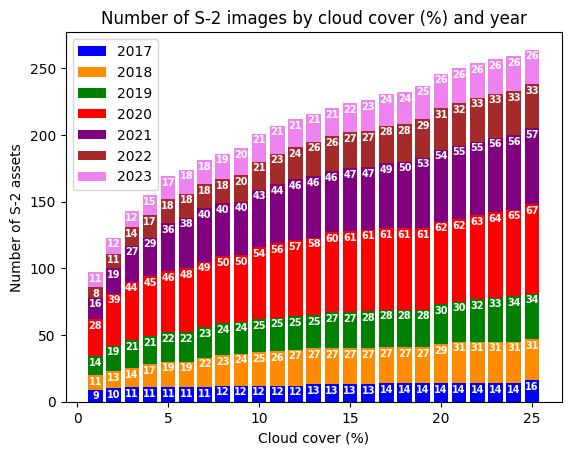

In [26]:
#make a pivot table, e.g. wide format for plotting:
df = pd.DataFrame(list(zip(cloudcover, year, results)), columns =['cloudcover', 'year', 'results'])
dfp = df.pivot_table(index='cloudcover', columns='year', values='results')

#plot
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()

colors = ["blue", "darkorange", "green", "red", "purple", "brown", "violet"]
bottom = np.zeros(len(dfp))

for i, col in enumerate(dfp.columns):
  ax.bar(
      dfp.index, dfp[col], bottom=bottom, label=col, color=colors[i])
  bottom += np.array(dfp[col])

totals = dfp.sum(axis=1)
#y_offset = 4
y_offset = -7

for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() + y_offset,
      round(bar.get_height()),
      ha='center',
      color='w',
      weight = 'bold',
      size=7
  )

ax.set_title('Number of S-2 images by cloud cover (%) and year')
ax.set_ylabel('Number of S-2 assets')
ax.set_xlabel('Cloud cover (%)')
ax.legend()
plt.show()

This bar plot reveals some interesting information that wasn't so obvious from descriptive statistics alone: that some years are far better than others for data. e.g. 2019 was a very cloudy year for Matto Gross state, Brazil!

**Below**, to keep the analysis relatively light, I reverted my search results back to the 2015-2023 date range, with a maximum cloud coverage of 5% as my catalogue search parameters: 

In [27]:
#Sticking with the 5% cloud cover for the rest of the analysis:

search_results = catalog.search(search_parameters=catalog.construct_search_parameters(
    geometry= bounds,
    start_date="2015-06-24", 
    end_date="2023-12-05",
    collections=[data_products.get("Sentinel-2").get("collection")],
    max_cloudcover=5, 
    limit=300))
len(search_results)

2023-12-07 14:47:48,287 - Searching catalog with search_parameters: {'datetime': '2015-06-24T00:00:00Z/2023-12-05T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358)),)}, 'limit': 300, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 5}}}
2023-12-07 14:47:53,554 - 169 results returned.


169

### Filtering 

A number of good quality Sentinel-2 images are now available in `search_results`. However, some extra considerations should be taken for how and when to measure NDVI.

To get a good NDVI result, I implemented extra conditions:
1. The AOI is in the Brazilian state of Matto Grosso, which is in the tropics, and experiences a dry-wet seasons.
2. Vegetation is most likely at its strongest and densest immediately following the wet season.
3. Measuring NDVI at the end of the wet season should give a good idea of the realistic area and extent of vegetation, since there is less risk of certain plants shedding foliage, or not reflecting enough nIR seasonally.
3. Therefore, I selected the should of month leading into the dry season: May, and further filtered the results for only images in this month.
4. I selected one random scene in May for each year of data availability (2017-2023).

In [28]:
subset = search_results[search_results['acquisitionDate'].str.contains('-05-')] #subset to May acquisitions
sub = subset.copy()
sub['year'] = subset['acquisitionDate'].str[:4]
subset = subset.loc[sub.groupby('year').sample(1, random_state=1).index.values.tolist()] #random date selection

### Placing the subsetted order.

Here I looped through each image in the the search results, placing an order for each one. Note this order took about 45 minutes to complete, in case you are looking to replicate.

Note the need to accept the EULA (End User License Agreement) for the data source first, otherwise you will receive an error.<br>
This can be done at https://console.up42.com/settings/

In [29]:
ids = subset.id.tolist()
orders = []
images_ids = []

for idx, id in enumerate(ids):
    order_parameters = catalog.construct_order_parameters(
        data_product_id=data_product_id, image_id=subset.id.iloc[idx])
    catalog.estimate_order(order_parameters)
    order = catalog.place_order(order_parameters, track_status=True)
    orders.append(order)
    images_ids.append(order_parameters['params']['id'])

2023-12-07 14:49:34,854 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.
2023-12-07 14:49:39,087 - Order is estimated to cost 0 UP42 credits (order_parameters: {'dataProduct': 'c3de9ed8-f6e5-4bb5-a157-f6430ba756da', 'params': {'id': 'S2A_21LXF_20170507_0_L2A'}})
2023-12-07 14:49:42,288 - Order is PLACED
2023-12-07 14:49:42,289 - Order c4bd5162-f5ce-4ab0-8ce4-db5804cd3d19 is now PLACED.
2023-12-07 14:49:42,292 - Tracking order status, reporting every 120 seconds...
2023-12-07 14:49:42,539 - Order is PLACED
2023-12-07 14:49:42,777 - Order is PLACED
2023-12-07 14:51:43,239 - Order is BEING_FULFILLED
2023-12-07 14:51:43,485 - Order is BEING_FULFILLED
2023-12-07 14:51:43,702 - Order is BEING_FULFILLED! - c4bd5162-f5ce-4ab0-8ce4-db5804cd3d19
2023-12-07 14:51:43,703 - 
2023-12-07 14:53:43,927 - Order is BEING_FULFILLED
2023-12-07 14:53:44,175 - Order is BEING_FULFILLED
2023-12-07 14:53:44,519 - Order is BEING_FULFILLED! - c4bd5162-f5ce-4ab0-8c

# Downloading STAC assets

Once the order was fulfilled, I chose to again iterate through each order and take the STAC assets of interest in each annual May scene. 

In this application, I was interested in the 4th, 8th, and _SCL_ assets, as these corrspond to the red, near infrared (abbreviated from here forwards as _nIR_), and image classification bands. The first two are needed to calculate NDVI, while the lattermost allows for the construction of a mask to remove cloud cover and the shadows they cast from the images, which will skew NDVI values down as they cover vegetation and other objects on the ground.

These data were output to the _/data_ folder and into a sub-folder with the name of the S-2 scene the assets belong to. The GeoTIFF images themselves retain the simple band numbers or names they correspond to.

In [30]:
bands = ["b04.tiff", "b08.tiff", "scl.tiff"] #4 is red, 8 is NIR, and scl is land class in S-2 products
for i in range(0, len(orders)):
    asset = up42.initialize_order(order_id=orders[i].order_id).get_assets()[0]
    stac_items = asset.stac_items
    stac_assets = stac_items[0].assets
    for band in bands:
        print("Downloading", band, "band...")
        asset.download_stac_asset(
        stac_asset=stac_assets.get(band),
        output_directory=pathlib.Path(root, "data/", ids[i]),
    )

2023-12-07 15:33:31,785 - Initialized Order(order_id: c4bd5162-f5ce-4ab0-8ce4-db5804cd3d19, assets: ['0baf2a35-9f5d-42fd-a2a6-959168671dbc'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T14:49:40.452506Z, updatedAt: 2023-12-07T14:55:01.309348Z)
2023-12-07 15:33:31,973 - Order is FULFILLED
2023-12-07 15:33:34,188 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:33:34,189 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20170507_0_L2A


193726it [00:43, 4413.20it/s]
2023-12-07 15:34:18,772 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20170507_0_L2A/b04.tiff
2023-12-07 15:34:18,788 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:34:18,792 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20170507_0_L2A


223084it [00:45, 4892.43it/s]
2023-12-07 15:35:04,953 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20170507_0_L2A/b08.tiff
2023-12-07 15:35:04,959 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:35:04,964 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20170507_0_L2A


650it [00:00, 2756.14it/s]
2023-12-07 15:35:05,888 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20170507_0_L2A/scl.tiff
2023-12-07 15:35:06,137 - Initialized Order(order_id: b1f3fe2f-1988-4294-b801-a486bbb68831, assets: ['64b0ac54-d5fd-45b5-acd7-9f8a93d2acbe'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T14:55:50.824509Z, updatedAt: 2023-12-07T15:00:34.452019Z)
2023-12-07 15:35:06,348 - Order is FULFILLED
2023-12-07 15:35:08,531 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:35:08,532 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20180502_0_L2A


190327it [00:39, 4853.52it/s]
2023-12-07 15:35:48,356 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20180502_0_L2A/b04.tiff
2023-12-07 15:35:48,361 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:35:48,363 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20180502_0_L2A


223193it [00:50, 4438.62it/s]
2023-12-07 15:36:39,107 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20180502_0_L2A/b08.tiff
2023-12-07 15:36:39,122 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:36:39,123 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20180502_0_L2A


552it [00:00, 3283.09it/s]
2023-12-07 15:36:39,831 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20180502_0_L2A/scl.tiff
2023-12-07 15:36:40,177 - Initialized Order(order_id: fdfd4197-7b20-4cd0-aab5-91c4b926e36c, assets: ['5a29524c-ee91-4ff4-9107-aa5fed9cdf4f'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T15:02:01.004940Z, updatedAt: 2023-12-07T15:07:51.129518Z)
2023-12-07 15:36:40,402 - Order is FULFILLED
2023-12-07 15:36:43,096 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:36:43,101 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20190527_0_L2A


213888it [00:54, 3899.66it/s]
2023-12-07 15:37:38,494 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20190527_0_L2A/b04.tiff
2023-12-07 15:37:38,499 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:37:38,501 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20190527_0_L2A


232766it [00:59, 3936.84it/s]
2023-12-07 15:38:38,161 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20190527_0_L2A/b08.tiff
2023-12-07 15:38:38,169 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:38:38,173 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20190527_0_L2A


2366it [00:00, 4057.29it/s]
2023-12-07 15:38:39,344 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20190527_0_L2A/scl.tiff
2023-12-07 15:38:39,590 - Initialized Order(order_id: f8ff2cad-19a3-44b3-90a5-0c9811475f56, assets: ['dd16857b-d59c-467a-9558-44be3c85358b'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T15:08:10.311119Z, updatedAt: 2023-12-07T15:12:39.624194Z)
2023-12-07 15:38:39,859 - Order is FULFILLED
2023-12-07 15:38:41,827 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:38:41,829 - Download directory: /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20200526_1_L2A


198664it [00:41, 4735.72it/s]
2023-12-07 15:39:24,266 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20200526_1_L2A/b04.tiff
2023-12-07 15:39:24,282 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:39:24,285 - Download directory: /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20200526_1_L2A


222855it [00:44, 5007.37it/s]
2023-12-07 15:40:09,398 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20200526_1_L2A/b08.tiff
2023-12-07 15:40:09,405 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:40:09,410 - Download directory: /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20200526_1_L2A


1210it [00:00, 3836.38it/s]
2023-12-07 15:40:10,219 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20200526_1_L2A/scl.tiff
2023-12-07 15:40:10,470 - Initialized Order(order_id: 86b6d4a9-4c4c-44d1-8c4c-4a3317345f4a, assets: ['5c5b5c97-b09d-42a4-8294-0159dd417e6b'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T15:14:20.701940Z, updatedAt: 2023-12-07T15:18:57.141084Z)
2023-12-07 15:40:10,681 - Order is FULFILLED
2023-12-07 15:40:12,925 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:40:12,929 - Download directory: /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20210501_1_L2A


205457it [00:43, 4741.00it/s]
2023-12-07 15:40:56,753 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20210501_1_L2A/b04.tiff
2023-12-07 15:40:56,761 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:40:56,762 - Download directory: /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20210501_1_L2A


226234it [00:46, 4887.42it/s]
2023-12-07 15:41:43,714 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20210501_1_L2A/b08.tiff
2023-12-07 15:41:43,739 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:41:43,740 - Download directory: /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20210501_1_L2A


1533it [00:00, 2247.51it/s]
2023-12-07 15:41:44,993 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2B_21LXF_20210501_1_L2A/scl.tiff
2023-12-07 15:41:45,411 - Initialized Order(order_id: fe7e97db-d880-427c-81ac-3724acdac7cb, assets: ['6850fa0a-3378-4473-a6b7-53999ef22c8f'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T15:20:30.997354Z, updatedAt: 2023-12-07T15:25:37.166001Z)
2023-12-07 15:41:46,561 - Order is FULFILLED
2023-12-07 15:41:48,643 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:41:48,646 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20220501_0_L2A


190162it [00:38, 4989.99it/s]
2023-12-07 15:42:27,312 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20220501_0_L2A/b04.tiff
2023-12-07 15:42:27,316 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:42:27,318 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20220501_0_L2A


217119it [00:44, 4873.80it/s]
2023-12-07 15:43:12,348 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20220501_0_L2A/b08.tiff
2023-12-07 15:43:12,354 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:43:12,356 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20220501_0_L2A


660it [00:00, 3020.40it/s]
2023-12-07 15:43:13,067 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20220501_0_L2A/scl.tiff
2023-12-07 15:43:13,254 - Initialized Order(order_id: 52922fff-f6d0-44d7-9236-adeb8588bddd, assets: ['65288236-6340-4285-83d3-2a4deadb6b24'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-07T15:26:40.478920Z, updatedAt: 2023-12-07T15:31:45.286424Z)
2023-12-07 15:43:13,524 - Order is FULFILLED
2023-12-07 15:43:15,866 - Downloading STAC asset Red (band 4) - 10m
2023-12-07 15:43:15,869 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20230516_0_L2A


191134it [00:39, 4881.02it/s]
2023-12-07 15:43:55,490 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20230516_0_L2A/b04.tiff
2023-12-07 15:43:55,499 - Downloading STAC asset NIR 1 (band 8) - 10m
2023-12-07 15:43:55,503 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20230516_0_L2A


219677it [00:47, 4628.55it/s]
2023-12-07 15:44:43,487 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20230516_0_L2A/b08.tiff
2023-12-07 15:44:43,497 - Downloading STAC asset Scene classification map (SCL)
2023-12-07 15:44:43,507 - Download directory: /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20230516_0_L2A


706it [00:00, 2954.44it/s]
2023-12-07 15:44:44,287 - Successfully downloaded the file at /Users/jsmith/Desktop/challenge/data/S2A_21LXF_20230516_0_L2A/scl.tiff


## Raster test 

In the block below, I am just plotting a raster in no particular order, to demonstrate a quick visualization. 
It is almost certainly more efficient to simply plot a thumbnail image of the scene, but this way there is a 
legend for reference.

Note that the values in said legend are very high in surface reflectance products for Sentinel-2 data. They represent percentage of solar energy reflected off the earth's surface, but are multipled by 1000 to keep data storage lower. If you're worried about what the units mean.

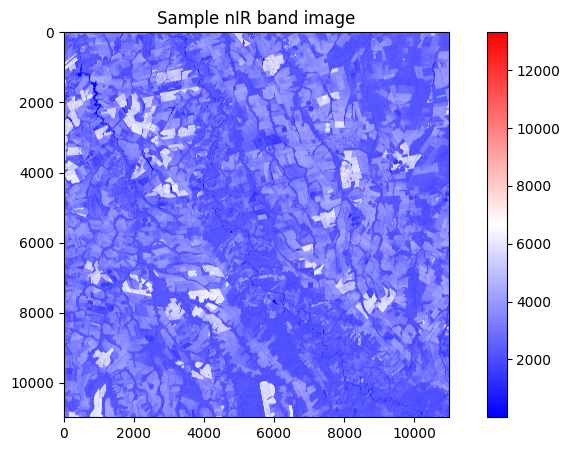

In [34]:
with rasterio.open(pathlib.Path(root, "data/", ids[6], "b08.tiff")) as src:
    red1 = src.read(1)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("Sample nIR band image")
    im = ax.imshow(red1, cmap='bwr')
    fig.colorbar(im)
    plt.show()

# Pre-processing section

Now the data has arrived without interacting with the UP-42 platform GUI. 

In this section I did the raw data processing. Steps are outlined below to get the 7 NDVI images of the Amazonas AOI (as opposed to the entire scene). 

First I had to resample the land classification layer. Referring to [Sentinel-2 documentation](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2#:~:text=20%20m%3A%20containing%20spectral%20bands,provides%20more%20precise%20spectral%20information.), the SCL asset/band is one of few with a 20 m spatial resolution, which does not accord well with red and nIR being in 10 m, especially when interacting in numpy. This needed to be resampled to follow the array dimensions of the red and nIR bands.

Then, iteratively, I :
1. Read in each band into memory as numpy array;
2. Clipped the scene to the AOI extent (_amazonas.geojson_);
3. Calculated NDVI as: NIR - RED / NIR + RED;
4. Recorded summary statistics of NDVI (mean, max, min);
5. Wrote the result array out to a GeoTIFF.


In [35]:
#Defining a re-sampling function to match the resolution of the S-2 bands to the SCL band:

def resample_raster(src, match):
    with rasterio.open(src) as src:
        with rasterio.open(match) as match:
            data = src.read(
                out_shape=(
                    src.count,
                    match.height,
                    match.width
                ),
                resampling=Resampling.bilinear
            )
            kwargs = src.meta.copy()
            kwargs.update({
                'height': match.height,
                'width': match.width,
                'transform': match.transform
            })
            with rasterio.open(src.name, 'w', **kwargs) as dst:
                dst.write(data)



In [36]:
# loop to clip images and calculate NDVI, record simple statistics. 

means = []
mins = []
maxs = []

for id in ids:
    
    print(id)

    resample_raster(pathlib.Path(root, "data/", id, "scl.tiff"), pathlib.Path(root, "data/", ids[0], "b08.tiff"))

    with rasterio.open(pathlib.Path(root, 'data', id, "b04.tiff"), 'r+') as ds1:
        out_red, out_red_transform=mask(ds1,copy.geometry,crop=True, nodata=9999)
    with rasterio.open(pathlib.Path(root,'data', id, "b08.tiff"), 'r+') as ds2:
        out_nir, out_nir_transform=mask(ds2,copy.geometry,crop=True, nodata=9999)
    with rasterio.open(pathlib.Path(root,'data', id, "scl.tiff"), 'r+') as ds3:
        out_scl, out_scl_transform=mask(ds3,copy.geometry,crop=True, nodata=9999)
    
        maskby = np.where((out_scl == 3) | (out_scl == 8) | (out_scl == 9) | (out_scl == 10), 0, 1)
        maskby = maskby.astype('float')
        maskby[maskby == 0] = 'nan'
        mask_red = out_red * maskby
        mask_nir = out_nir * maskby

    ndvi = np.zeros(mask_red.shape, dtype=rasterio.float32)
    ndvi = (mask_nir.astype(float)-mask_red.astype(float))/(mask_nir+mask_red)

    print("NDVI mean:", np.nanmean(ndvi))
    means.append(np.nanmean(ndvi))
    mins.append(np.nanmin(ndvi))
    maxs.append(np.nanmax(ndvi))

    out_meta=ds1.meta.copy() # copy the metadata of the source DEM
    out_meta.update({
        "driver":"Gtiff",
        "dtype":rasterio.float32,
        "height":mask_red.shape[1], # height starts with shape[1]
        "width":mask_red.shape[2], # width starts with shape[2]
        "transform":out_red_transform,
        "nodata":9999
    })

    with rasterio.open(pathlib.Path(root,'data', id, "ndvi.tiff"), 'w', **out_meta) as dst:
        dst.write(ndvi.astype(rasterio.float32))
print("done")



S2A_21LXF_20170507_0_L2A
NDVI mean: 0.7852468657797603
S2A_21LXF_20180502_0_L2A
NDVI mean: 0.79503672811489
S2A_21LXF_20190527_0_L2A
NDVI mean: 0.6634377388672453
S2B_21LXF_20200526_1_L2A
NDVI mean: 0.7162995927957309
S2B_21LXF_20210501_1_L2A
NDVI mean: 0.7484214395883277
S2A_21LXF_20220501_0_L2A
NDVI mean: 0.7683179060742995
S2A_21LXF_20230516_0_L2A
NDVI mean: 0.7938851851718615
done


# Data visualizations

In this section, I produced for Green-Plant some visualizations to help assess what's changed in their AOI over the years, using just NDVI-related outputs from the free Sentinel-2 data they requested. I made a number of data visualizations to highlight different types of outputs they might expect or hope for. Of course, there's always more that can be done. The numbered list below lays out, in order, the visualization deliverables descriptions.

1. A typical NDVI output raster;
2. A plot showing mean, max, and min NDVI over each May;
3. The NDVI difference between the first year (2017), and the most recent year (2023);
4. A set of 7 histograms suggesting some shift in higher NDVI values in the latter years (regeneration? Or agricultural crop cycling?). 
5. A reclassified raster map, showing some areas with a net positive increase in NDVI, and the area it occupies (similarly, some has remained the same, or decreased).
6. A 6-panel plot of NDVI over 2018-2023, for visual comparison of patterns.  


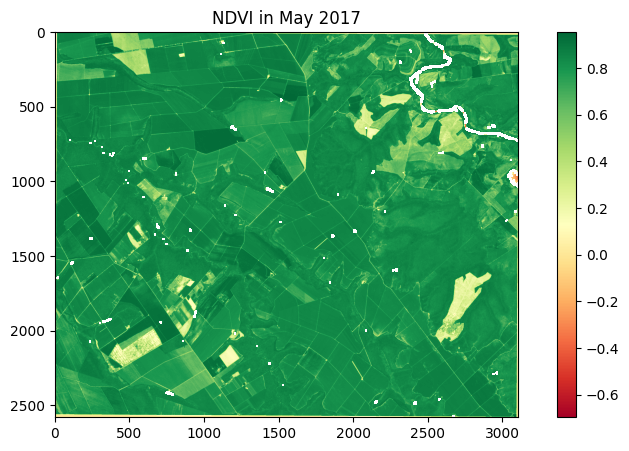

In [37]:
#1 Sample NDVI image, with increasing NDVI moving from red to green:
with rasterio.open(pathlib.Path(root, 'data', "S2A_21LXF_20170507_0_L2A", "ndvi.tiff"), 'r+') as ds1:
    ndvi1 = ds1.read(1)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("NDVI in May 2017")
    im = ax.imshow(ndvi1, cmap='RdYlGn', vmin = np.nanmin(ndvi1), vmax = np.nanmax(ndvi1))
    fig.colorbar(im)
    plt.imshow(ndvi1, cmap='RdYlGn')

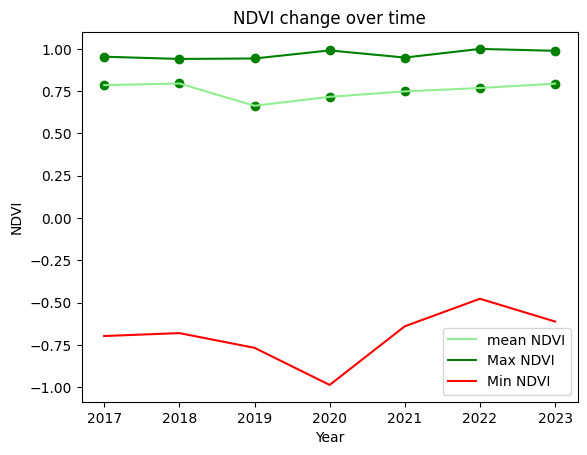

In [38]:
#2 Line/scatter plot of mean, min, max NDVI over time:
year = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

plt.scatter(year, means, color='green')
plt.scatter(year, maxs, color='green')
plt.plot(year, means, color='lightgreen', label='mean NDVI')
plt.plot(year, maxs, color='green', label='Max NDVI')
plt.plot(year, mins, color='red', label='Min NDVI')
plt.xlabel('Year')
plt.ylabel('NDVI')
plt.title('NDVI change over time')
#plt.plot(year, mins, color='green', label='Max NDVI')
plt.legend()
plt.show()

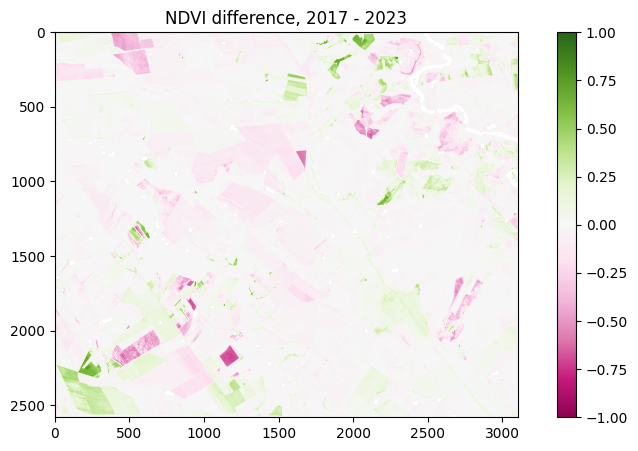

In [55]:
#3
#python reads directories in alphabetical order, so this sorts the folders by year to get the correct order
#before calculating the difference raster.
#using np.abs() would be an alternative to find where differences occur without respect to gain/loss of vegetation specifically.
# Note that higher difference values indicate the vegetation was denser in 2017 than 2023.

data_folder = pathlib.Path(root, 'data')
folders = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, f))]
#sort the folders in the order of the years they contain inside the string:
folders = sorted(folders, key=lambda x: x[10:14])

ndvi_variables = []
for folder in folders:
    with rasterio.open(pathlib.Path(root, 'data', folder, "ndvi.tiff")) as src:
        #print(pathlib.Path(root, 'data', folder, "ndvi.tiff"))
        ndvi = src.read(1)
        ndvi_variables.append(ndvi)

dif = (ndvi_variables[0] - ndvi_variables[6]) #
with rasterio.open(pathlib.Path(root, "ndvi_dif.tiff"), 'w', **ds1.meta) as dst:
    dst.write(dif, indexes=1)

cmap = 'PiYG'
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("NDVI difference, 2017 - 2023")
im = ax.imshow(dif, cmap=cmap, vmin = -1, vmax = 1)
fig.colorbar(im)
plt.show()

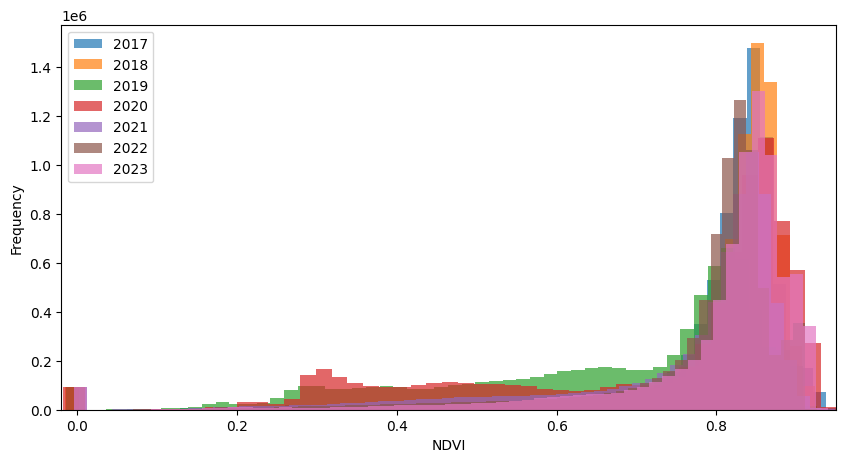

In [44]:
#4
#The plot is a bit difficult to discern, but shifted distributions are evidence of change on the ground. 
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ndvi_variables[0][~np.isnan(ndvi_variables[0])], bins=100, alpha = 0.7, label='2017')
ax.hist(ndvi_variables[1][~np.isnan(ndvi_variables[1])], bins=100, alpha = 0.7, label='2018')
ax.hist(ndvi_variables[2][~np.isnan(ndvi_variables[2])], bins=100, alpha = 0.7, label='2019')
ax.hist(ndvi_variables[3][~np.isnan(ndvi_variables[3])], bins=100, alpha = 0.7, label='2020')
ax.hist(ndvi_variables[4][~np.isnan(ndvi_variables[4])], bins=100, alpha = 0.7, label='2021')
ax.hist(ndvi_variables[5][~np.isnan(ndvi_variables[5])], bins=100, alpha = 0.7, label='2022')
ax.hist(ndvi_variables[6][~np.isnan(ndvi_variables[6])], bins=100, alpha = 0.7, label='2023')
plt.xlim(-0.02  , 0.95)
plt.legend(loc='upper left')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.show()

There was a net growth area of NDVI in the AOI of 486.5432 km^2
As a percentage of the AOI area, this corresponds to  60.0 %


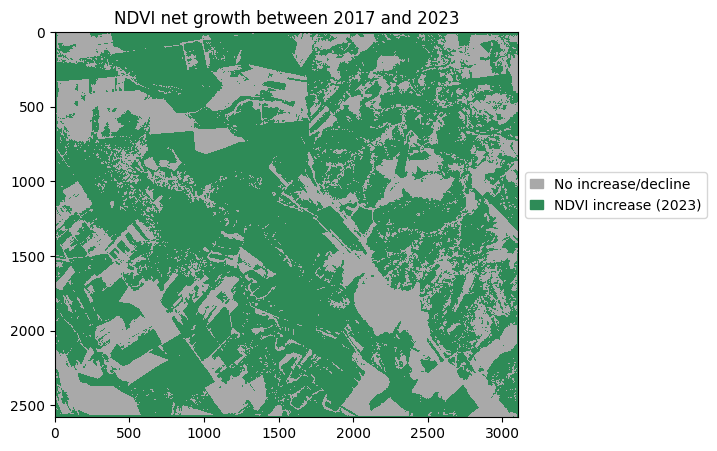

In [53]:
#5
## reclassify the raster to show just positive and negative changes
## in this case, green is positive and black is negative (or null values due to cloud cover)

reclass = dif.copy()
reclass[np.where(reclass < 0 )] = 0
reclass[np.where(reclass > 0 )] = 1
reclass[np.isnan(reclass)] = 0

n_pix = np.count_nonzero(reclass == 0)
sqm = np.absolute(out_meta['transform'][0] * out_meta['transform'][4]) * n_pix
ndvi_growth_sqkm = sqm / 1000000

n_pix_tot = (out_meta['width'] * out_meta['height']) 
n_pix_sqkm = n_pix_tot * np.absolute(out_meta['transform'][0] * out_meta['transform'][4]) / 1000000

ndvi_growth_percent = ndvi_growth_sqkm / n_pix_sqkm
print("There was a net growth area of NDVI in the AOI of", ndvi_growth_sqkm , "km^2")
print("As a percentage of the AOI area, this corresponds to ", np.round(ndvi_growth_percent,1) * 100 , "%")

cmap = ListedColormap(['seagreen', 'darkgrey'])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("NDVI net growth between 2017 and 2023")
im = ax.imshow(reclass, cmap=cmap, vmin = 0, vmax = 1)

class1 = mpatches.Patch(color='darkgrey', label='No increase/decline')
class2 = mpatches.Patch(color='seagreen', label='NDVI increase (2023)')

ax.legend(handles=[class1,class2],
          handlelength=0.9,bbox_to_anchor=(1, 0.5),loc='lower left')
plt.show()


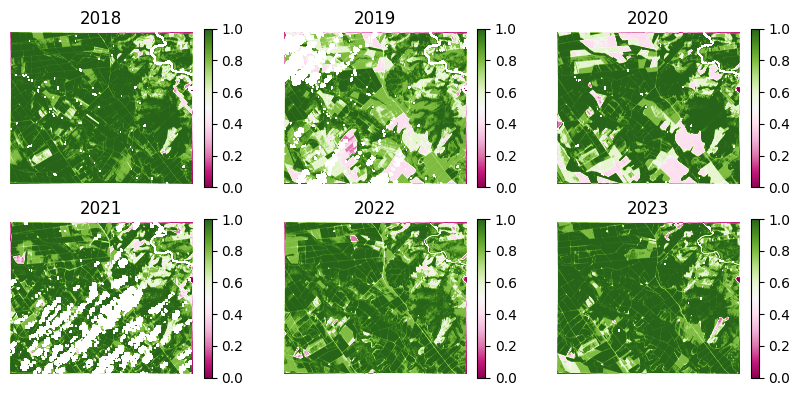

In [54]:
#Show a six plot panel of NDVI images reclassified to into bins of 0.2 NDVI units each:

# create figure 
fig = plt.figure(figsize=(10, 7)) 
  
# setting values to rows and column variables 
rows = 3
columns = 3
for i in range(1,7):
    classes = ndvi_variables[i].copy()
    classes[np.where( classes < 0 )] = 0.0
    classes[np.where((0.0 < classes) & (classes < 0.2)) ] = 0.2
    classes[np.where((0.2 < classes) & (classes < 0.4)) ] = 0.4
    classes[np.where((0.4 < classes) & (classes < 0.6)) ] = 0.6
    classes[np.where((0.6 < classes) & (classes < 0.8)) ] = 0.8
    classes[np.where(classes > 0.8 )] = 1.0

    fig.add_subplot(rows, columns, i) 
    im = plt.imshow(classes, cmap='PiYG', vmin = np.nanmin(classes), vmax = np.nanmax(classes))
    fig.colorbar(im)
    plt.axis('off') 
    plt.title(2017+i)

# Analysis & Conclusion

This was a very simple, quick analysis of NDVI at only 7 time steps. The AOI appears to be an area that had some forest felling activity possibly prior to 2017. This is obvious from the very angular patterns of fields (which are likely either agricultural in nature, or felled compartments of trees). In some NDVI outputs, it looks as though certain fields are increasing in NDVI in recent years, for example the comparison between 2017 and 2023 shown above. This could be a natural regeneration process taking place, or it could just simply be grasses and crops growing in harvest periods, which is not necessarily indicative of a healthy natural habitat. 

A a closer look is needed at overall annual trends. e.g. Taking a large number of NDVI images and plotting descriptive statistics over more years, across possibly another sensor. This method is more complex as NDVI will take on a sinusoidal relationship due to its being affected strongly by seasonality. More sophisticated time series tools would be needed to check if the difference in NDVI over time is statistically significant. I recommend something on the order of hundreds of images to paint as robust a picture of the real effect as possible

Here, I've shown some basic applications that that are made possible by calling STAC items using the UP42 SDK:
Green-Plant Gmbh can check a sample NDVI output for their AOI, which allows for a quick check to see if any parcels of land are in a dire shape (low, or negative NDVI scores, suggesting deforestation).

By tracking images in May over a few years, we can see an overall trend to increasing NDVI from 2018 on. This relationship may be simply by chance alone, and further analysis is needed to confirm or deny. These differences could also be explained by better or worse climatic conditions that affect NDVI of the local vegetation. 

The difference raster shows areas in the AOI that have been most affected, and can inform in-situ investigations in the corresponding areas. The histogram suggests a trend is increasing. It is important to note that these are comparisons between a few time steps only, and -again- more permutations would help ascertain if this trend is real.

<span style="color:green">Green-Plant Gmbh</span> is now equipped to add additional functionality to this workflow, and tweak existing elements as needed to suit their objectives. e.g. monitoring current or further de-forestation activity, or to monitor their efforts at rehabilitating presently fallow parcels of land.



# Reflections

Given more time I would try the following:

1. Order more images, sampling randomly across seasons to the aim of plotting a sinusoidal function of NDVI, and ascertain a better understanding of its seasonal variation. If the sine curve trends down/upwards, that's a sign something is changing on the ground. 
2. More sophisticated NDVI differencing. Perhaps calculating percentage change over NDVI between all permutations of years and looking for patterns in those outputs. 
3. Zooming in on a select few of the agricultural/felled woodland parcels so as to monitor their change rather than just the AOI at large. This may reveal activities about how these parcels are being treated: e.g. are they converted to crops, or re-wilding efforts?
4. Experiment further with various SDK classes and STAC functionality.

# FIN 👋

Thank you for giving me the opportunity to give a go at this challenge! I enjoyed learning about how some of UP42's development tools work, and learned some new Python tricks along the way, too. 😊

*All work in this notebook is my own, and I did not use any additional time than was agreed upon. 
